# Финальный проект по блоку "Uplift - моделирование"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import causalml.metrics as cmetrics

## Загрузка данных

In [2]:
# клиенты
df_clients = pd.read_csv('datasets/customers.csv', index_col=0)
df_clients

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


,customer_id,age,location
0,0,56,Oxenfurt
1,1,53,Hindarsfjall
2,2,41,Hindarsfjall
3,3,60,Kaer_Trolde
4,4,22,Spikeroog
...,...,...,...
1999995,1999995,23,Novigrad
1999996,1999996,48,Spikeroog
1999997,1999997,43,Spikeroog
1999998,1999998,20,Novigrad


In [3]:
# Покупки
df_ord = pd.read_parquet('datasets/receipts.parquet')
df_ord

,customer_id,date,purchase_amt,discount,purchase_sum
26,26,0,12.125273,0,970.021866
53,53,0,34.357035,0,2748.562788
56,56,0,8.695825,0,695.666022
58,58,0,28.299046,0,2263.923641
64,64,0,32.547511,0,2603.800857
...,...,...,...,...,...
1999979,1999979,249,29.084863,0,2326.789054
1999980,1999980,249,4.907042,0,392.563365
1999982,1999982,249,5.016101,0,401.288094
1999992,1999992,249,9.171240,0,733.699220


In [4]:
# Кампании
df_camp = pd.read_csv('datasets/campaigns.csv', index_col=0)
df_camp

,customer_id,n_offer_days,date,target_group_flag
0,0,7,102,1
1,1,7,102,1
2,2,7,102,1
3,3,7,102,1
4,4,7,102,1
...,...,...,...,...
499995,499995,7,102,1
499996,499996,7,102,1
499997,499997,7,102,1
499998,499998,7,102,1


500 тыс клиентов случайных клиентов из 2 млн получили оффер.
Оффером можно воспользоваться с 102 по 108 день.
Оффер = discount = 40 уе

Неоходимо подготовить список клиентов, которым нужно отправить оффер,
чтобы максимизировать прибыль с учетом затрат на оффер.

Маржа на единицу товара: 80 - 52 = 28 уе  
Стоимость оффера: 40 (бонус) + 1(доставка сообщения) = 41 уе  
Метрики рассчитываются за период 30 дней с начала действия скидки  


## Генерация признаков по портрету клиента

In [5]:
from sklearn.model_selection import train_test_split

In [71]:
# Временно
data = df_clients.copy()
data

,customer_id,age,location
0,0,56,Oxenfurt
1,1,53,Hindarsfjall
2,2,41,Hindarsfjall
3,3,60,Kaer_Trolde
4,4,22,Spikeroog
...,...,...,...
1999995,1999995,23,Novigrad
1999996,1999996,48,Spikeroog
1999997,1999997,43,Spikeroog
1999998,1999998,20,Novigrad


In [72]:
data = pd.concat([data, pd.get_dummies(data['location'], dtype=float)], axis=1)
data

,customer_id,age,location,Beauclair,Crows_perch,Hindarsfjall,Kaer_Trolde,Novigrad,Oxenfurt,Spikeroog
0,0,56,Oxenfurt,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,53,Hindarsfjall,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2,41,Hindarsfjall,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3,60,Kaer_Trolde,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,22,Spikeroog,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1999995,1999995,23,Novigrad,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1999996,1999996,48,Spikeroog,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1999997,1999997,43,Spikeroog,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1999998,1999998,20,Novigrad,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Признаки по клиентским заказам

In [73]:
# Давность
START_DATE = 102
df_ord_before_camp = df_ord[df_ord['date'] < START_DATE]
df_rec = df_ord_before_camp.groupby('customer_id').agg(**{
    'rec': ('date', 'max')
}).reset_index()
df_rec['rec'] = START_DATE - df_rec['rec']
data = data.merge(df_rec, how='left', on='customer_id').fillna(value={'rec': START_DATE + 1})
data

,customer_id,age,location,Beauclair,Crows_perch,Hindarsfjall,Kaer_Trolde,Novigrad,Oxenfurt,Spikeroog,rec
0,0,56,Oxenfurt,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0
1,1,53,Hindarsfjall,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20.0
2,2,41,Hindarsfjall,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
3,3,60,Kaer_Trolde,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24.0
4,4,22,Spikeroog,0.0,0.0,0.0,0.0,0.0,0.0,1.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...
1999995,1999995,23,Novigrad,0.0,0.0,0.0,0.0,1.0,0.0,0.0,15.0
1999996,1999996,48,Spikeroog,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0
1999997,1999997,43,Spikeroog,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0
1999998,1999998,20,Novigrad,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0


In [75]:
# Кол-во заказов и маржа
DEPTHS = [15, 30, 60, 90]
for depth in DEPTHS:
    df_ord_depth = df_ord[df_ord['date'].between(START_DATE - depth, START_DATE - 1)]
    df_g = df_ord_depth.groupby('customer_id').agg(**{
        f"n_ord_{depth}": ('date', 'count'),
        f"margin_{depth}": ('purchase_amt', 'sum'),
    })
    df_g[f"margin_{depth}"] = df_g[f"margin_{depth}"] * 28
    data = data.merge(df_g, how='left', on='customer_id').fillna(value={f"n_ord_{depth}": 0, f"margin_{depth}": 0})
data

,customer_id,age,location,Beauclair,Crows_perch,Hindarsfjall,Kaer_Trolde,Novigrad,Oxenfurt,Spikeroog,rec,n_ord_15,margin_15,n_ord_30,margin_30,n_ord_60,margin_60,n_ord_90,margin_90
0,0,56,Oxenfurt,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,1.0,336.786430,2.0,655.930064,6.0,1805.951698,10.0,2898.313391
1,1,53,Hindarsfjall,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20.0,0.0,0.000000,2.0,695.046305,4.0,1308.357640,6.0,1978.215277
2,2,41,Hindarsfjall,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,1095.742192,2.0,1095.742192,5.0,3445.765717,7.0,4599.764712
3,3,60,Kaer_Trolde,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24.0,0.0,0.000000,1.0,1186.996294,3.0,3008.300501,7.0,4811.652113
4,4,22,Spikeroog,0.0,0.0,0.0,0.0,0.0,0.0,1.0,16.0,0.0,0.000000,1.0,623.091146,2.0,1152.507578,2.0,1152.507578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,1999995,23,Novigrad,0.0,0.0,0.0,0.0,1.0,0.0,0.0,15.0,1.0,498.707501,2.0,1139.713862,5.0,2379.611847,9.0,4383.984380
1999996,1999996,48,Spikeroog,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,2.0,438.980112,4.0,1431.388604,6.0,2432.661674,9.0,3704.467930
1999997,1999997,43,Spikeroog,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,347.580545,3.0,1074.486415,6.0,1962.633413,9.0,2678.339938
1999998,1999998,20,Novigrad,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,1.0,404.137581,1.0,404.137581,3.0,652.987140,3.0,652.987140


## Добавляю флаг воздействия и таргет

In [76]:
# Добавляю флаг воздействия
data = data.merge(df_camp[['customer_id', 'target_group_flag']], how='left', on='customer_id')
data = data.fillna(value={'target_group_flag': 0})
data['target_group_flag'] = data['target_group_flag'].astype(int)
data

,customer_id,age,location,Beauclair,Crows_perch,Hindarsfjall,Kaer_Trolde,Novigrad,Oxenfurt,Spikeroog,rec,n_ord_15,margin_15,n_ord_30,margin_30,n_ord_60,margin_60,n_ord_90,margin_90,target_group_flag
0,0,56,Oxenfurt,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,1.0,336.786430,2.0,655.930064,6.0,1805.951698,10.0,2898.313391,1
1,1,53,Hindarsfjall,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20.0,0.0,0.000000,2.0,695.046305,4.0,1308.357640,6.0,1978.215277,1
2,2,41,Hindarsfjall,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,1095.742192,2.0,1095.742192,5.0,3445.765717,7.0,4599.764712,1
3,3,60,Kaer_Trolde,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24.0,0.0,0.000000,1.0,1186.996294,3.0,3008.300501,7.0,4811.652113,1
4,4,22,Spikeroog,0.0,0.0,0.0,0.0,0.0,0.0,1.0,16.0,0.0,0.000000,1.0,623.091146,2.0,1152.507578,2.0,1152.507578,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,1999995,23,Novigrad,0.0,0.0,0.0,0.0,1.0,0.0,0.0,15.0,1.0,498.707501,2.0,1139.713862,5.0,2379.611847,9.0,4383.984380,0
1999996,1999996,48,Spikeroog,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,2.0,438.980112,4.0,1431.388604,6.0,2432.661674,9.0,3704.467930,0
1999997,1999997,43,Spikeroog,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,347.580545,3.0,1074.486415,6.0,1962.633413,9.0,2678.339938,0
1999998,1999998,20,Novigrad,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,1.0,404.137581,1.0,404.137581,3.0,652.987140,3.0,652.987140,0


In [77]:
# Добавляю целевую переменную - маржу за 30 дней после начала действия скидки
# Заказы за 30 дней
df_ord_target = df_ord[(df_ord['date'] >= 102) & (df_ord['date'] < 132)]
# Стоимость отправки сообщения
df_ord_target['message_cost'] = np.heaviside(df_ord_target['discount'].values, 0)
# Маржа
df_ord_target['target_margin_30'] = df_ord_target['purchase_amt'] * 28 \
                - df_ord_target['discount'] - df_ord_target['message_cost']
df_ord_target


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,customer_id,date,purchase_amt,discount,purchase_sum,message_cost,target_margin_30
12,12,102,14.351911,40,1148.152907,1.0,360.853518
19,19,102,3.840616,40,307.249242,1.0,66.537235
39,39,102,12.696186,40,1015.694904,1.0,314.493217
72,72,102,24.732437,40,1978.594946,1.0,651.508231
86,86,102,16.100635,40,1288.050801,1.0,409.817780
...,...,...,...,...,...,...,...
1999947,1999947,131,14.454914,0,1156.393153,0.0,404.737604
1999966,1999966,131,33.984350,0,2718.747961,0.0,951.561786
1999969,1999969,131,10.550683,0,844.054619,0.0,295.419117
1999977,1999977,131,7.756212,0,620.496937,0.0,217.173928


In [78]:
df_ord_target_g = df_ord_target.groupby('customer_id').agg({'target_margin_30': 'sum'})
df_ord_target_g

,target_margin_30
customer_id,
0,847.568339
1,882.030697
2,1469.691792
3,2609.562982
4,361.654491
...,...
1999994,1253.976234
1999995,1927.602365
1999996,985.734871


In [79]:
# Добавляю маржу по заказам
data = data.merge(df_ord_target_g, how='left', on='customer_id')

# Но надо еще посчитать маржу по тем, кто не совершил заказ
# Получили сообщение, но не совершили заказ
data.loc[(data['target_margin_30'].isna()) & (data['target_group_flag'] == 1), 'target_margin_30'] = -1
# Оставшиеся клиенты просто не совершили заказ (без сообщения)
data = data.fillna(value={'target_margin_30': 0})
data

,customer_id,age,location,Beauclair,Crows_perch,Hindarsfjall,Kaer_Trolde,Novigrad,Oxenfurt,Spikeroog,...,n_ord_15,margin_15,n_ord_30,margin_30,n_ord_60,margin_60,n_ord_90,margin_90,target_group_flag,target_margin_30
0,0,56,Oxenfurt,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,336.786430,2.0,655.930064,6.0,1805.951698,10.0,2898.313391,1,847.568339
1,1,53,Hindarsfjall,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,2.0,695.046305,4.0,1308.357640,6.0,1978.215277,1,882.030697
2,2,41,Hindarsfjall,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.0,1095.742192,2.0,1095.742192,5.0,3445.765717,7.0,4599.764712,1,1469.691792
3,3,60,Kaer_Trolde,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.000000,1.0,1186.996294,3.0,3008.300501,7.0,4811.652113,1,2609.562982
4,4,22,Spikeroog,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.000000,1.0,623.091146,2.0,1152.507578,2.0,1152.507578,1,361.654491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,1999995,23,Novigrad,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,498.707501,2.0,1139.713862,5.0,2379.611847,9.0,4383.984380,0,1927.602365
1999996,1999996,48,Spikeroog,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,2.0,438.980112,4.0,1431.388604,6.0,2432.661674,9.0,3704.467930,0,985.734871
1999997,1999997,43,Spikeroog,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,347.580545,3.0,1074.486415,6.0,1962.633413,9.0,2678.339938,0,711.491999
1999998,1999998,20,Novigrad,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,404.137581,1.0,404.137581,3.0,652.987140,3.0,652.987140,0,0.000000


In [80]:
fit_index, val_index = train_test_split(data.index, test_size=0.5, random_state=165)

In [81]:
# Проверка, что индекс всегда совпадает с customer_id
data[data.index != data['customer_id']]

,customer_id,age,location,Beauclair,Crows_perch,Hindarsfjall,Kaer_Trolde,Novigrad,Oxenfurt,Spikeroog,...,n_ord_15,margin_15,n_ord_30,margin_30,n_ord_60,margin_60,n_ord_90,margin_90,target_group_flag,target_margin_30


## Обучение модели

In [82]:
import causalml.inference.meta.rlearner as rlearner
import lightgbm as lgb

In [83]:
# Название колонки с флагом воздействия
col_treatment = 'target_group_flag'

In [84]:
# Колонки, которые будут участвовать в обучении модели
cols_features = ['age',
                 'Beauclair', 'Crows_perch', 'Hindarsfjall', 'Kaer_Trolde', 'Novigrad', 'Oxenfurt', 'Spikeroog',
                'rec'] + [f"n_ord_{d}" for d in DEPTHS] + [f"margin_{d}" for d in DEPTHS]

In [85]:
col_target = 'target_margin_30'

In [86]:
model_n1 = rlearner.BaseRRegressor(
    learner=lgb.LGBMRegressor(),
    control_name=0,
    n_fold=4,
    random_state=165
)

In [87]:
# Вероятность получить воздействие.
# Т.к. группу для воздействия выбирали случайно, то это просто доля клиентов с воздействием
_p_score_const = data.loc[fit_index, col_treatment].value_counts(normalize=True).loc[1]
_p_score_const

0.25007

In [88]:
_p_scores = pd.Series(data=_p_score_const, index=fit_index)
model_n1.fit(
    X=data.loc[fit_index, cols_features].values,
    treatment=data.loc[fit_index, col_treatment].values,
    y=data.loc[fit_index, col_target].values,
    p=_p_scores
)

## Предсказания

In [89]:
_eval_data = data.loc[val_index, cols_features + [col_treatment, col_target]]
_eval_data['score'] = model_n1.predict(_eval_data[cols_features])
_eval_data = _eval_data[['score', col_treatment, col_target]]

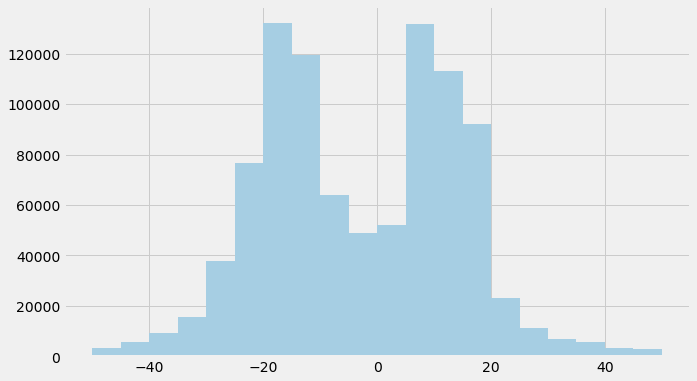

In [103]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'], bins=20, range=(-50, 50))
plt.show()

In [91]:
_eval_data['score'].describe()

count    1000000.000000
mean          -3.019914
std           29.800068
min        -1333.178823
25%          -16.227672
50%           -3.926481
75%           10.935497
max          807.920011
Name: score, dtype: float64

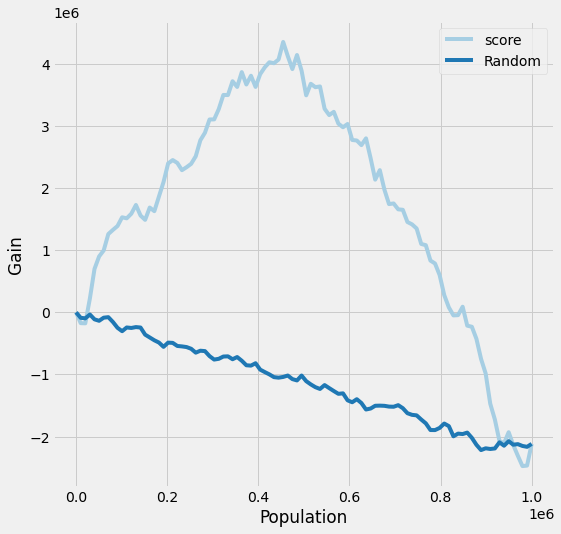

In [92]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

Кажется, что первые 450 тыс дают нам максимум маржи на вилидации  
Ожидаемая прибыль - 4 млн оренов

In [93]:
# Найдем граничного значение скора аплифт-модели
TOP_N = 450_000
threshold_uplift_score = _eval_data.sort_values(by='score', ascending=False).iloc[TOP_N, 0]
threshold_uplift_score

1.5638648698655655

## Подготовка датасета для предсказаний

In [94]:
# Здесь признаки расчитаны перед началом первой кампании.
# А нам нужны признаки сейчас.
df_pred = data.drop(columns=['rec'] + [f"n_ord_{d}" for d in DEPTHS] + [f"margin_{d}" for d in DEPTHS])
df_pred

,customer_id,age,location,Beauclair,Crows_perch,Hindarsfjall,Kaer_Trolde,Novigrad,Oxenfurt,Spikeroog,target_group_flag,target_margin_30
0,0,56,Oxenfurt,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,847.568339
1,1,53,Hindarsfjall,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,882.030697
2,2,41,Hindarsfjall,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1469.691792
3,3,60,Kaer_Trolde,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,2609.562982
4,4,22,Spikeroog,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,361.654491
...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,1999995,23,Novigrad,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1927.602365
1999996,1999996,48,Spikeroog,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,985.734871
1999997,1999997,43,Spikeroog,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,711.491999
1999998,1999998,20,Novigrad,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.000000


In [95]:
# давность
df_rec = df_ord.groupby('customer_id').agg(**{
    'rec': ('date', 'max')
})
df_rec['rec'] = df_ord['date'].max() - df_rec['rec'] + 1
df_pred = df_pred.merge(df_rec, how='left', on='customer_id')
df_pred

,customer_id,age,location,Beauclair,Crows_perch,Hindarsfjall,Kaer_Trolde,Novigrad,Oxenfurt,Spikeroog,target_group_flag,target_margin_30,rec
0,0,56,Oxenfurt,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,847.568339,9.0
1,1,53,Hindarsfjall,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,882.030697,5.0
2,2,41,Hindarsfjall,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1469.691792,4.0
3,3,60,Kaer_Trolde,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,2609.562982,11.0
4,4,22,Spikeroog,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,361.654491,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,1999995,23,Novigrad,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1927.602365,5.0
1999996,1999996,48,Spikeroog,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,985.734871,10.0
1999997,1999997,43,Spikeroog,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,711.491999,2.0
1999998,1999998,20,Novigrad,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.000000,5.0


In [96]:
# Кол-во заказов
MAX_DATE = df_ord['date'].max()
DEPTHS = [15, 30, 60, 90]
for depth in DEPTHS:
    df_ord_depth = df_ord[df_ord['date'] > MAX_DATE - depth]
    df_g = df_ord_depth.groupby('customer_id').agg(**{
        f"n_ord_{depth}": ('date', 'count'),
        f"margin_{depth}": ('purchase_amt', 'sum'),
    })
    df_pred = df_pred.merge(df_g, how='left', on='customer_id') \
        .fillna(value={f"n_ord_{depth}": 0, f"margin_{depth}": 0})
df_pred

,customer_id,age,location,Beauclair,Crows_perch,Hindarsfjall,Kaer_Trolde,Novigrad,Oxenfurt,Spikeroog,...,target_margin_30,rec,n_ord_15,margin_15,n_ord_30,margin_30,n_ord_60,margin_60,n_ord_90,margin_90
0,0,56,Oxenfurt,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,847.568339,9.0,1.0,9.964590,2.0,20.769769,7.0,62.964857,10.0,90.346609
1,1,53,Hindarsfjall,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,882.030697,5.0,1.0,10.517529,1.0,10.517529,3.0,33.431073,4.0,46.683563
2,2,41,Hindarsfjall,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1469.691792,4.0,2.0,73.011893,2.0,73.011893,5.0,165.795167,7.0,236.853407
3,3,60,Kaer_Trolde,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2609.562982,11.0,1.0,30.054258,1.0,30.054258,3.0,93.378358,6.0,184.740040
4,4,22,Spikeroog,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,361.654491,36.0,0.0,0.000000,0.0,0.000000,2.0,27.603203,3.0,39.654248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999995,1999995,23,Novigrad,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1927.602365,5.0,2.0,40.399200,4.0,74.800194,6.0,106.319692,8.0,135.655904
1999996,1999996,48,Spikeroog,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,985.734871,10.0,1.0,22.063390,2.0,42.989861,4.0,78.962049,6.0,112.878914
1999997,1999997,43,Spikeroog,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,711.491999,2.0,2.0,21.873408,4.0,44.572148,6.0,74.027834,6.0,74.027834
1999998,1999998,20,Novigrad,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.000000,5.0,2.0,46.025740,2.0,46.025740,2.0,46.025740,4.0,87.924847


In [97]:
# Проскорим всю клиентскую базу
_total_data = df_pred.loc[:, cols_features + [col_treatment, col_target]]
_total_data['score'] = model_n1.predict(_total_data[cols_features])
_total_data = _total_data[['score', col_treatment, col_target]]
_total_data.index.name = 'customer_id'
_total_data

,score,target_group_flag,target_margin_30
customer_id,,,
0,-15.022185,1,847.568339
1,5.930083,1,882.030697
2,-10.631940,1,1469.691792
3,-5.460207,1,2609.562982
4,17.241114,1,361.654491
...,...,...,...
1999995,-9.634669,0,1927.602365
1999996,-5.460207,0,985.734871
1999997,-6.631979,0,711.491999


In [98]:
df_result = _total_data[_total_data['score'] >= threshold_uplift_score]
df_result

,score,target_group_flag,target_margin_30
customer_id,,,
1,5.930083,1,882.030697
4,17.241114,1,361.654491
5,2.452900,1,1066.465745
9,10.578698,1,-1.000000
12,14.480231,1,360.853518
...,...,...,...
1999985,11.769475,0,0.000000
1999987,6.848436,0,0.000000
1999988,6.848436,0,1715.984003


In [99]:
df_result.reset_index()[['customer_id']].to_csv('solution.csv')

In [100]:
# Результат:
# Ваша кампания принесла более 4500000 оренов - превосходный результат.
# Получен максимальный балл